Iota Calculation, Fourier Surface Extraction, and Perturbations (Wendelstein 7-X)
=================================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid).cache("surfField.fsc")
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [3]:
xStart = np.linspace(5.65, 6.4, 100)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [ ]:
with fsc.backends.useBackend(fsc.backends.localBackend()):
    iotas = fsc.flt.calculateIota(
        field, [xStart, yStart, zStart],
        200, # Turn count
        unwrapEvery = 10, distanceLimit = 1e4, 
        targetError = 1e-3, minStepSize = 1e-3
    )

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

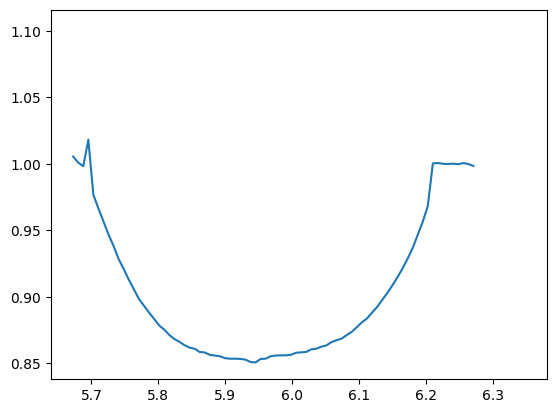

In [6]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [7]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    30, # Turn count
    nMax = 5, mMax = 7, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 1,
    targetError = 1e-3, distanceLimit = 1e5, maxStepSize = 0.01,
    stellaratorSymmetric = True, aliasThreshold = 0.05
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [8]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor'])

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [9]:
modes["iota"]

array([1.09296743, 1.05201799, 1.02192065, 0.95953866, 0.93201318,
       0.90885779, 0.89053899, 0.8778229 , 0.86878861, 0.86284406,
       0.85888718, 0.85629327, 0.85540308, 0.8528906 , 0.85458037,
       0.85631844, 0.85788384, 0.86048244, 0.86447436, 0.87003808,
       0.87785737, 0.88882675, 0.90355044, 0.92219878, 0.94640649,
       0.99973431, 0.99995699, 1.0000255 , 1.04787973, 1.08241185])

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [10]:
modes["theta"]

array([ 2.86637495e+00,  3.07766637e+00, -3.01389235e+00,  3.04642344e+00,
        3.08233143e+00,  3.08287865e+00,  3.05104405e+00,  3.06405752e+00,
        3.06594658e+00,  3.06676753e+00,  3.04789205e+00,  3.04920257e+00,
        3.06884125e+00,  3.06890056e+00, -4.33399011e-03, -1.56177577e-02,
       -3.64601199e-03, -5.51368530e-03,  1.14558629e-02,  6.03484252e-03,
       -8.80484327e-03,  1.84211962e-03,  1.43219667e-02, -2.01941820e-04,
       -1.62192781e-02, -2.29027181e-02, -7.31439266e-04, -3.57129582e-02,
       -1.95263684e-02, -9.05174586e-03])

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

In [11]:
surfaces = modes["surfaces"]

print(type(surfaces))
#print("First:\n", surfaces[0])
#print("Last:\n", surfaces[-1])
#print("Average:\n", (surfaces[0] + surfaces[-1]) / 2)
#for i in range(0, surfaces.shape[0]):
#    print(surfaces[i].data.rCos)
print(surfaces[-4].data.rCos)

<class 'fusionsc.magnetics.SurfaceArray'>
shape: [11, 8]
data: [5.4768804056963267, 0.5357715394978716, 0.08616725298860177, 0, 0, 0, 0, 0, 0.24876703545379245, -0.2534497998324674, 0.060435085298564326, 0, 0, 0, 0, 0, -0.0092448212902515765, -0.015347355894154858, 0.082366896577950016, 0, 0, 0, 0, 0, -0.0035084949637794187, 0.0049147018847759101, -0.0018620215912602104, 0, 0, 0, 0, 0, -0.0013348871334193028, 0.0019298281632950894, -0.0013484427603610175, 0, 0, 0, 0, 0, 0.00018728042527183829, 0.00014438648340008335, 0.00047911937236375953, 0, 0, 0, 0, 0, 0, 0.0004307223410333169, -0.00066578450940522112, 0.00026031097838393776, -0.00021464458046345915, -0.00050418403726311259, -0.00068061403030017736, 0.00077431061482350684, 0, -0.00078948922711825225, -0.00016404005073169831, 0, 0, 0, 0, 0, 0, 0.00098511771857025905, 0.001008954741848078, 0, 0, 0, 0, 0, 0, 0.0099168953849063223, -0.015903625700090521, 0, 0, 0, 0, 0, 0, 0.034890271596954889, -0.0060424763327021486, 0, 0, 0, 0, 0]


(3, 30, 3, 100)


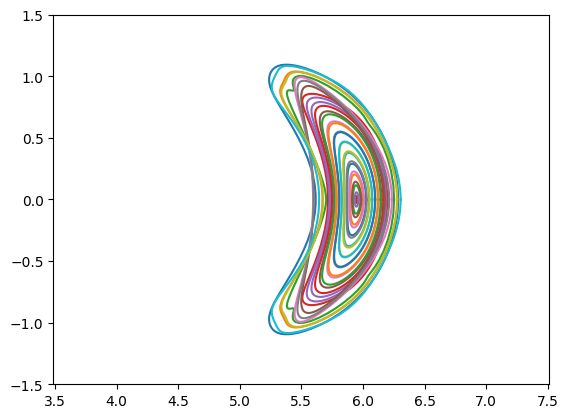

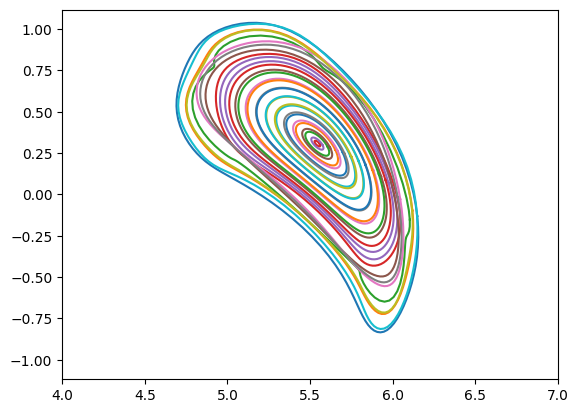

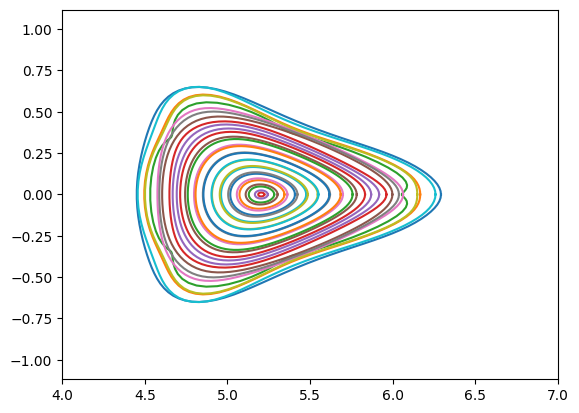

In [12]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 3)

data = surfaces.evaluate(phis, thetas) # Surfaces -5, -4, -3 are rational and failed to reconstruct

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, surfaces.shape[0]):
        #if abs(modes['iota'][iSurf] - 1) < 0.02:
        #    continue
            
        dp = 1
        x, y, z = data['points'][:,iSurf,iPhi,::dp]
        dx, dy, dz = data['thetaDerivatives'][:,iSurf,iPhi,::dp]
        
        r = np.sqrt(x**2 + y**2)
        
        dr = (dx * x + dy * y) / r
        
        
        plt.plot(r, z)
        #plt.quiver(r, z, dr, dz)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()

The obtained surfaces can also be used to calculate a mode decomposition of the magnetic field

In [13]:
surfaces[2].asGeometry(nPhi = 360, nTheta = 360).asPyvista().plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\_api_markers.py:15: UserWarning: The function fusionsc.magnetics.MagneticConfig.calculateRadialModes is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")
C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\magnetics.py:402: UserWarning: calculateRadialModes can only use the FFT fast path if nPhi == 2 * nMax + 1 and nTheta == 2 * mMax + 1. Other values are not recommended
  warnings.warn("calculateRadialModes can only use the FFT fast path if nPhi == 2 * nMax + 1 and nTheta == 2 * mMax + 1. Other values are not recommended")


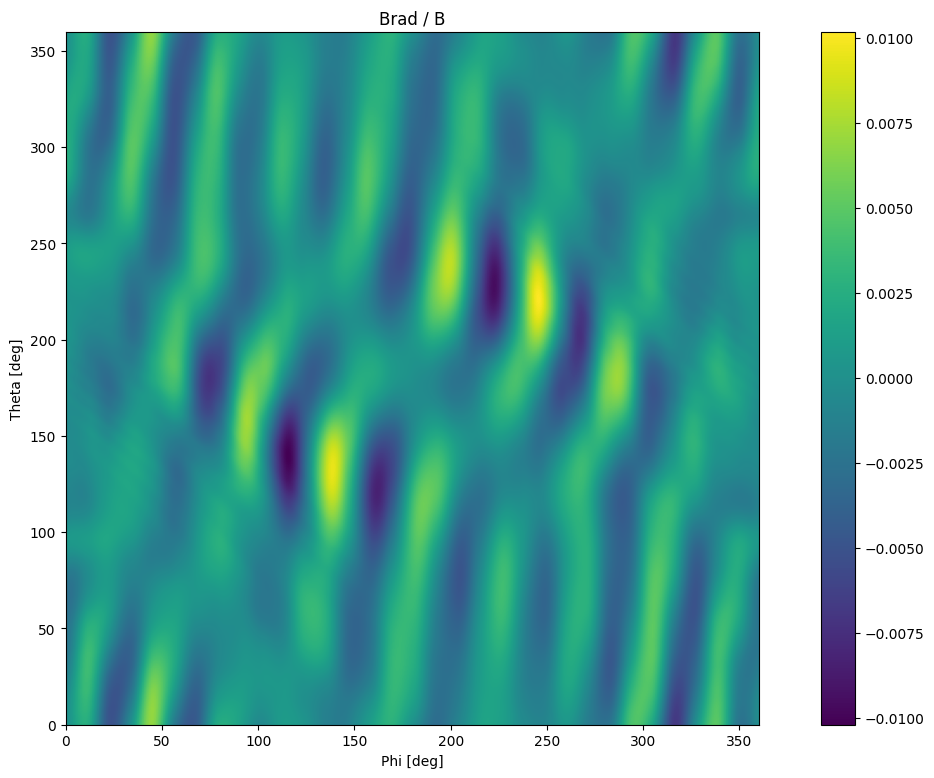

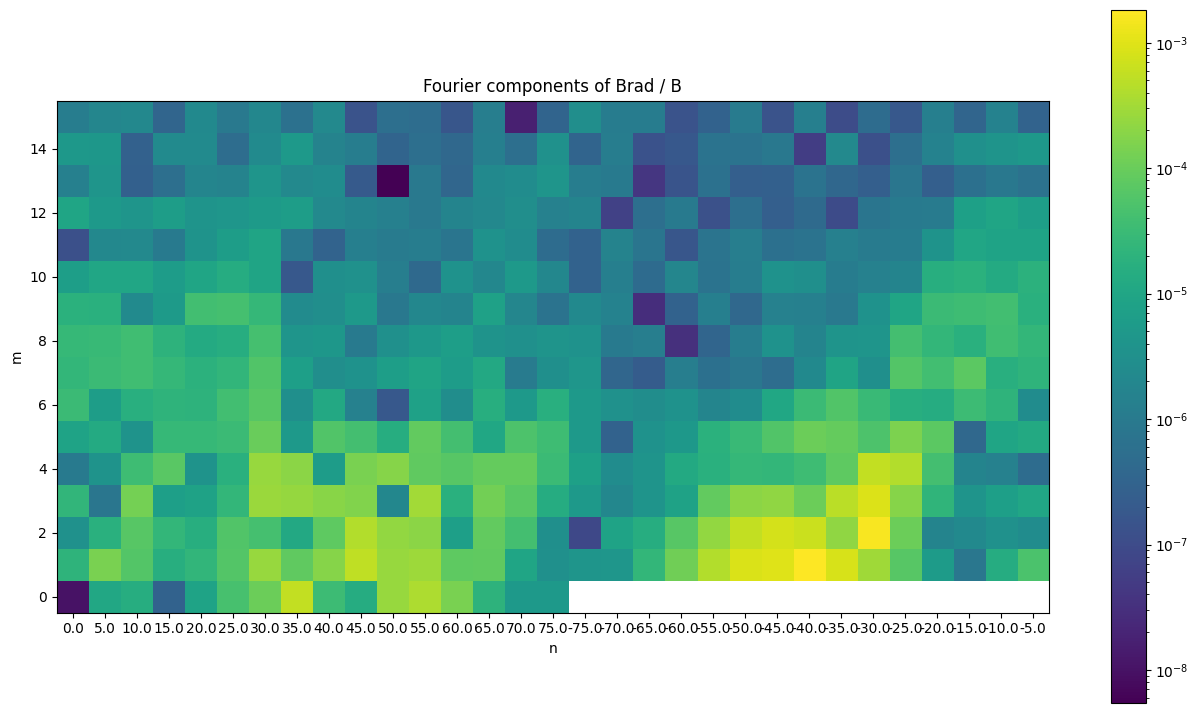

(400, 400)
n = 0, m = 0, val = 1.03e-08
n = 5, m = 0, val = 1.11e-05
n = 10, m = 0, val = 1.54e-05
n = 0, m = 1, val = 2.16e-05
n = 5, m = 1, val = 1.41e-04
n = 10, m = 1, val = 5.95e-05
n = 0, m = 2, val = 3.35e-06
n = 5, m = 2, val = 1.77e-05
n = 10, m = 2, val = 6.80e-05
n = 0, m = 3, val = 2.31e-05
n = 5, m = 3, val = 8.20e-07
n = 10, m = 3, val = 1.26e-04
n = 0, m = 4, val = 1.01e-06
n = 5, m = 4, val = 3.73e-06
n = 10, m = 4, val = 3.56e-05
n = 0, m = 5, val = 8.56e-06
n = 5, m = 5, val = 1.32e-05
n = 10, m = 5, val = 3.83e-06


In [14]:
surf = surfaces[6]
#np.asarray(surf.data.rCos)[0,0] += 0.03

fieldModes = field.calculateRadialModes(surf, field, nSym = 5, mMax = 15, nMax = 15, nTheta = 400, nPhi = 400)
cc = fieldModes["cosCoeffs"]
sc = fieldModes["sinCoeffs"]

m = fieldModes["mPol"]
n = fieldModes["nTor"]

phi = fieldModes["phi"]
theta = fieldModes["theta"]

tot = np.sqrt(cc**2 + sc**2)

plt.figure(figsize=(16,9))
plt.imshow(fieldModes["radialValues"].T, origin='lower', extent = [0, 360, 0, 360])
plt.colorbar()
plt.title("Brad / B")
plt.xlabel('Phi [deg]')
plt.ylabel('Theta [deg]')

plt.figure(figsize=(16,9))
plt.imshow(tot.T, origin = "lower", norm = "log")
#plt.xlabel(f"n[0, {n[1]:.0f} ... {max(n):.0f}, {min(n):.0f}, ..., {n[-1]:.0f}]")
plt.xlabel("n")
plt.ylabel("m")
plt.xticks(range(len(n)), n)
plt.title("Fourier components of Brad / B")
plt.colorbar()
plt.show()

print(fieldModes["radialValues"].shape)
for i_m, mVal in enumerate(m):
    for i_n, nVal in enumerate(n):
        if mVal > 5: continue
        if nVal < 0: continue
        if nVal > 10: continue
        print(f"n = {nVal:.0f}, m = {mVal:.0f}, val = {tot[i_n][i_m]:.2e}")


The calculated surfaces can also be converted into geometries to plot.

C:\Users\Alexander\AppData\Roaming\Python\Python310\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


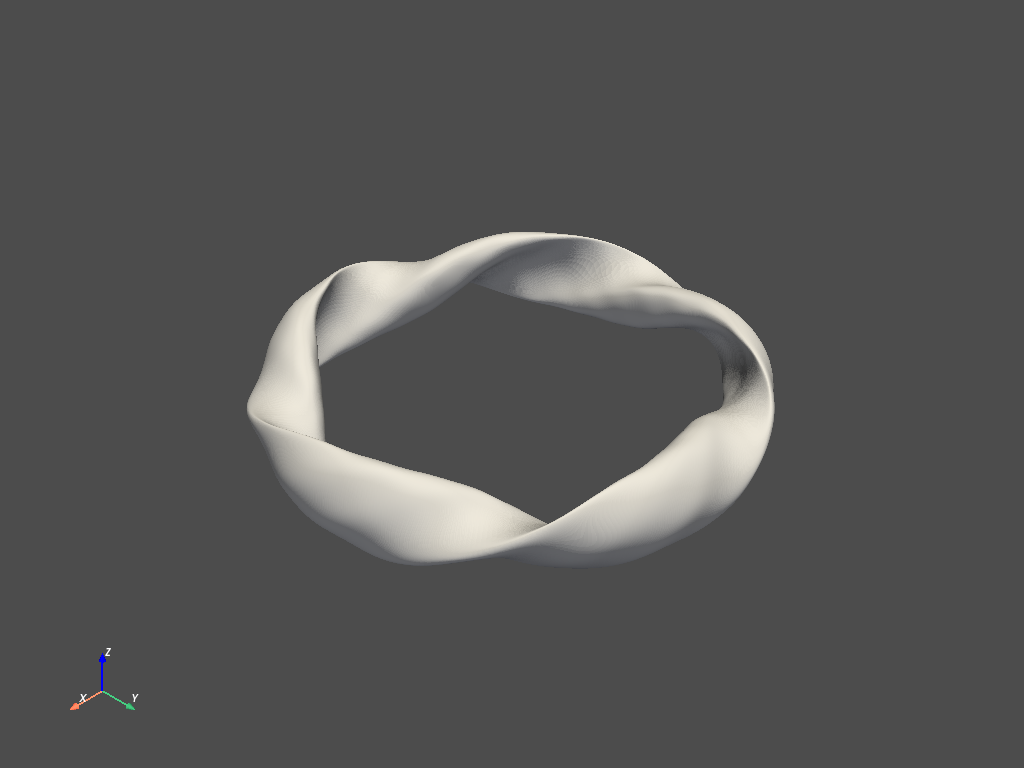

In [20]:
asPv = surfaces[0].asGeometry(nPhi = 360, nTheta = 360).asPyvista()
asPv.plot()

In [62]:
surfs = []

for phi in np.linspace(0, 2 * np.pi, 5, endpoint = False):
    rStart = -np.linspace(4.5, 4.65, 15)
    
    xStart = np.cos(phi) * rStart
    yStart = np.sin(phi) * rStart
    zStart = 0 * xStart

    print(xStart, yStart)
    
    modes2 = fsc.flt.calculateFourierModes(
        field, [xStart, yStart, zStart],
        30, # Turn count
        nMax = 5, mMax = 7, toroidalSymmetry = 5,
        unwrapEvery = 10, recordEvery = 1,
        targetError = 1e-3, distanceLimit = 1e5, maxStepSize = 0.01,
        stellaratorSymmetric = False, aliasThreshold = 0.05,
        islandM = 5
    )

    surfs.append(modes2["surfaces"])

[-4.5        -4.51071429 -4.52142857 -4.53214286 -4.54285714 -4.55357143
 -4.56428571 -4.575      -4.58571429 -4.59642857 -4.60714286 -4.61785714
 -4.62857143 -4.63928571 -4.65      ] [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
[-1.39057647 -1.39388737 -1.39719827 -1.40050916 -1.40382006 -1.40713096
 -1.41044185 -1.41375275 -1.41706365 -1.42037454 -1.42368544 -1.42699633
 -1.43030723 -1.43361813 -1.43692902] [-4.27975432 -4.28994421 -4.30013411 -4.310324   -4.32051389 -4.33070378
 -4.34089367 -4.35108356 -4.36127345 -4.37146334 -4.38165324 -4.39184313
 -4.40203302 -4.41222291 -4.4224128 ]
[3.64057647 3.64924451 3.65791255 3.66658059 3.67524863 3.68391667
 3.69258471 3.70125275 3.70992079 3.71858883 3.72725687 3.73592491
 3.74459295 3.75326098 3.76192902] [-2.64503364 -2.65133133 -2.65762903 -2.66392673 -2.67022443 -2.67652213
 -2.68281983 -2.68911753 -2.69541523 -2.70171293 -2.70801063 -2.71430833
 -2.72060602 -2.72690372 -2.73320142]
[3.64057647 3.64924451 3.65791255

In [69]:
geo = sum([s[14].asGeometry(nPhi = 360, nTheta = 360) for s in surfs])
geo = geo.planarClip(normal = [1,0,0])
geo.asPyvista().plot(notebook = False)

In [23]:
surfaces2.asGeometry(nPhi = 360, nTheta = 360).asPyvista().plot(notebook = False)